# Investigating DICOM meta data attributes

In [ ]:
from utils.common_imports import *
from tqdm import tqdm
import re
from glob import glob
# from utils.utils import get_scan_directory_path_by_patient_id, get_ct_scan_slices

ImportError: cannot import name 'get_scan_directory_path_by_patient_id' from 'utils.utils' (/Users/newuser/Documents/ITU/master_thesis/utils/utils.py)

In [2]:
dicom_image = pydicom.dcmread("/Users/newuser/Documents/ITU/master_thesis/data/lung_data/manifest-1725363397135/LIDC-IDRI/LIDC-IDRI-0001/01-01-2000-NA-NA-30178/3000566.000000-NA-03192/1-057.dcm")
dicom_image

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 206
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.14519.5.2.1.6279.6001.313544823773855097029348077255
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.3.6.1.4.1.22213.1.143
(0002, 0013) Implementation Version Name         SH: '0.5'
(0002, 0016) Source Application Entity Title     AE: 'POSDA'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL']
(0008, 0016) SOP Class UID                       UI: CT Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.6.1.4.1.14519.5.2.1.6279.6001.31354

In [3]:
# a FileDataset object is a dictionary-like object
# see class documentation: https://pydicom.github.io/pydicom/stable/reference/generated/pydicom.dataset.FileDataset.html#pydicom.dataset.FileDataset

def get_dicom_vals(dicom_file: pydicom.dataset.FileDataset):
    """Returns the values of the dicom image in a clean format"""
    vals = [v for _, v in dicom_file.to_json_dict().items()]
    return_vals = []
    for v in vals:
        if isinstance(v, dict):
            if "Value" in v:
                if len(v["Value"]) == 1:
                    return_vals.append(v["Value"][0])
                else:
                    return_vals.append(v["Value"])
            else:
                return_vals.append(None)
        else:
            raise ValueError(f"Value is not a dict: {type(v)}")

    return return_vals

def get_dicom_keys(dicom_file: pydicom.dataset.FileDataset):
    """Returns the keys of the dicom image in a clean format"""
    return_keys = []
    extract_key = lambda k: re.sub(r'\s+', ' ', k.split(")")[1][1:].split(":")[0])
    for _, val in dicom_image.items():
        k = extract_key(str(val))
        return_keys.append(k)
    return return_keys

def parse_dicom_to_dict(dicom_file: pydicom.dataset.FileDataset):
    return dict(zip(get_dicom_keys(dicom_file), get_dicom_vals(dicom_file)))

In [32]:
# Load all dicom files in a patient scan directory
# and check if the meta keys are consistent across all files
def collect_meta_fields(patient_scan_dir: str, meta_attributes: list[str] | None = None) -> dict:
    """
    Fetches all meta data dicom fields from a patient scan dir (a single scan).
    Each meta data value from each slice is appended to a list with the key of the
    attribute as the list name.
    # TODO add a list input of attributes that only fetches those if specified
    """
    patient_scan_paths = sorted(glob(f"{patient_scan_dir}/*.dcm"))
    collected_meta_fields = {}
    for s in patient_scan_paths:
        with pydicom.dcmread(fp=s, force=True, specific_tags=["KVP"]) as dicom_image:
            # NOTE: the print statement (or pixel_array access) forces the image to be read into memory. Do not remove.
            # print(dicom_image)
            try:
                dicom_image.pixel_array
            except Exception as e:
                print(dicom_image)
            dict = parse_dicom_to_dict(dicom_image)

        for k, v in dict.items():
            if k not in collected_meta_fields:
                collected_meta_fields[k] = []
            collected_meta_fields[k].append(v)

    return collected_meta_fields

In [ ]:
patient_scan_dir = "/Users/newuser/Documents/ITU/master_thesis/data/lung_data/manifest-1725363397135/LIDC-IDRI/LIDC-IDRI-0001/01-01-2000-NA-NA-30178/3000566.000000-NA-03192"
collected_meta_fields = collect_meta_fields(patient_scan_dir)
res_keys = list(collected_meta_fields.keys())

# Visualise Meta-data distributions


In [36]:
list(collected_meta_fields.keys())

['Specific Character Set CS', 'Image Type CS']

In [38]:
from typing import Any


# inputs
attribute = "KVP"


vals = []
for pid in tqdm(config.patient_ids):
    patient_scan_dir = get_scan_directory_path_by_patient_id(pid)
    cif = collect_meta_fields(patient_scan_dir)
    vals.extend(cif[attribute])

  0%|          | 0/500 [00:00<?, ?it/s]

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 206
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.14519.5.2.1.6279.6001.262721256650280657946440242654
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.3.6.1.4.1.22213.1.143
(0002, 0013) Implementation Version Name         SH: '0.5'
(0002, 0016) Source Application Entity Title     AE: 'POSDA'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0018, 0060) KVP                                 DS: '120.0'
Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 206
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Me

KeyError: 'KVP'

<Axes: >

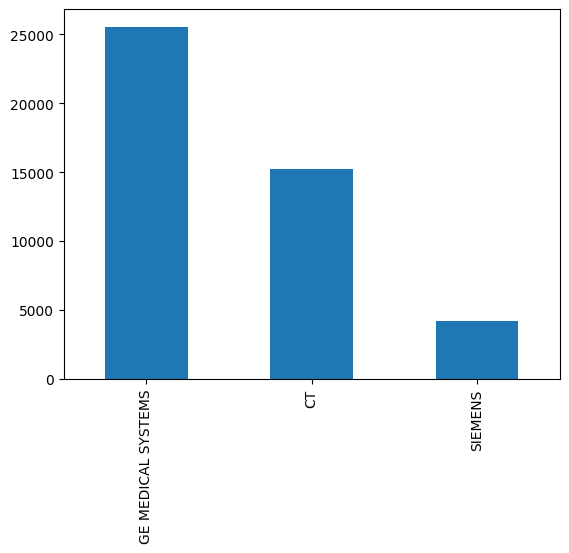

In [29]:
pd.Series(vals).value_counts()[:3].plot(kind="bar")

# Make .csv file

In [23]:
# check that all meta data for all dicom images in the scan are equal
def all_equal(lst: list) -> bool:
    """Checks if all elements in the list are equal (to the first element)"""
    first_element = lst[0]
    return all([first_element == x for x in lst])

def all_equal_dict(d: dict) -> list[bool]:
    """Assumes a dictionary with list values is given. Checks if all lists are equal"""
    return [all_equal(v) for _, v in d.items()]

In [ ]:
# # make .csv file with all the meta data checking that they are equal across all patient scans
all_patient_ids = sorted([d for d in os.listdir(config.DATA_DIR) if "LIDC-IDRI" in d])

df_dicts = []

# c = 0
for pid in tqdm(all_patient_ids):
    pid_scan_file_dir = get_scan_directory_path_by_patient_id(patient_id_dir=pid)
    collected_meta_fields = collect_meta_fields(pid_scan_file_dir)
    equal_results = all_equal_dict(collected_meta_fields)
    df_dicts.append({k: v for k, v in zip(res_keys, equal_results)})

    # if c == 10:
    #     break
    # c += 1

In [28]:
df = pd.DataFrame(df_dicts, index=all_patient_ids)
# df.to_excel("out/meta_data_check.xlsx")